In [233]:
###Import
import sys

#import geobayes_simple as gs
from matplotlib import pyplot as plt
from IPython.core.display import Image

%matplotlib inline
import pymc as pm
from pymc.Matplot import plot
import numpy as np
from IPython.core.pylabtools import figsize
figsize(10, 3)
import seaborn
seaborn.set_context(font_scale=2)
seaborn.set_style("white")

from pymc import graph

import scipy.optimize as sop
import scipy.stats as stats
import matplotlib.mlab as mlab

### Simple 1-dimensional reservoir case: Modelling reservoir and seal

- abstract 1D case allows for a straightforward way to develop a preliminary and simplified model of a reservoir and respectively the development of a loss function
- here: 3 layer-interfaces model inherited from the work by De la Varga (2016) with adaptions made to represent a very abstract but in that way reasonable model of a reservoir system
- this case assumes the two layers of interest to form a petroleum system consisting of reservoir and seal in the subsurface
- very simplified and abstract just to illustrate the fundamental approach of this work

In [234]:
###Distributions for boundary locations
alpha = pm.Normal("alpha", -2000, 1./np.square(7.))
beta = pm.Normal("beta", -2050, 1./np.square(25))
gamma = pm.Normal("gamma", -2200, 1./np.square(45))

###Model
model = pm.Model([alpha, beta, gamma])

In [235]:
###PyMC simulation
M = pm.MCMC(model)
M.sample(iter=5000)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.7 sec

In [236]:
alpha_samples = M.trace('alpha')[:]
beta_samples = M.trace('beta')[:]
gamma_samples = M.trace('gamma')[:]

alpha_samples, alpha_samples_all = M.trace('alpha')[-80:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[-80:], M.trace("beta")[:]
gamma_samples, gamma_samples_all = M.trace('gamma')[-80:], M.trace('gamma')[:]

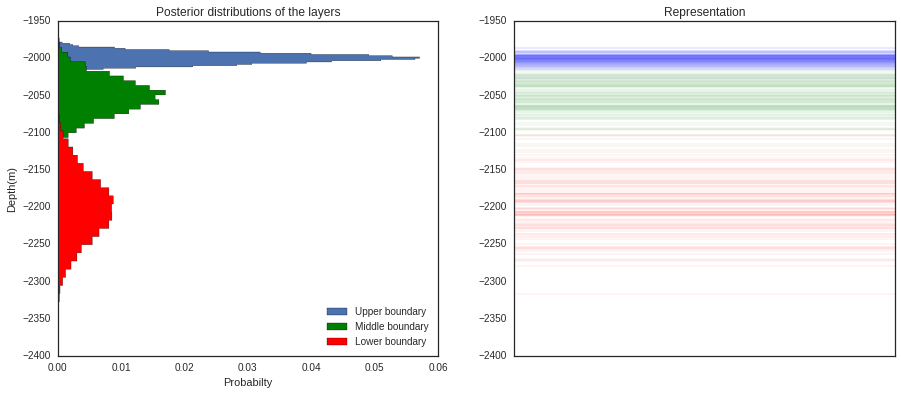

In [237]:
figsize(15,6)
fig, ax = plt.subplots(1, 2)

ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
    label="Upper boundary", normed=True,  orientation="horizontal")
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
    label="Middle boundary", normed=True, color = "g",  orientation="horizontal")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
 label="Lower boundary", normed=True, color = "r", orientation="horizontal")

ax[0].legend(loc = 0)
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_ylabel("Depth(m)")
ax[0].set_ylim([-2400,-1950])
ax[0].set_xlabel("Probabilty")

ax[1].set_title("Representation")
ax[1].set_ylim([-2400,-1950])
ax[1].xaxis.set_visible(False)
for i in range(100):
    ax[1].axhline(alpha_samples_all[i], alpha = 0.05)
    ax[1].axhline(beta_samples_all[i], c = "g", alpha = 0.05)
    ax[1].axhline(gamma_samples_all[i],c = "r", alpha = 0.05)

- describe the case referencing the figure above

In [238]:
seal_thickness = (alpha_samples_all - beta_samples_all)
reservoir_thickness = (beta_samples_all - gamma_samples_all)
reservoir_depth = beta_samples_all

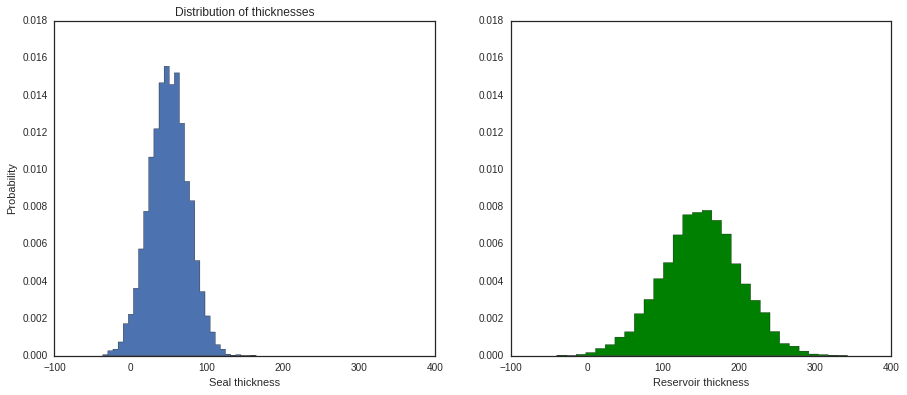

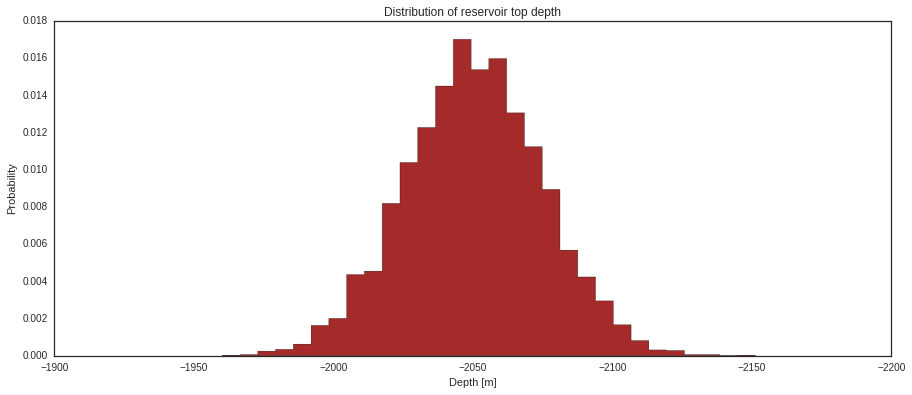

In [239]:
figsize(15,6)
fig, ax = plt.subplots(1, 2)

ax[0].hist(seal_thickness, histtype='stepfilled', bins=30, alpha=1,
    label="Seal", normed=True)
ax[1].hist(reservoir_thickness, histtype='stepfilled', bins=30, alpha=1,
    label="Reservoir", normed=True, color = "g")

ax[0].set_title(r"""Distribution of thicknesses""")
ax[0].set_ylabel("Probability")
ax[0].set_xlabel("Seal thickness")
ax[1].set_xlabel("Reservoir thickness")
ax[0].set_xlim([-100,400])
ax[1].set_xlim([-100,400])
ax[0].set_ylim([0,0.018])
ax[1].set_ylim([0,0.018])

fig, ax = plt.subplots(1, 1)
plt.hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
 label="Reservoir Depth", normed=True, color = "brown")

ax.set_title(r"""Distribution of reservoir top depth""")
ax.set_ylabel("Probability")
ax.set_xlabel("Depth [m]")
ax.set_xlim([-1900,-2200])
ax.set_ylim([0,0.018]);

- relevant uncertain parameters in the model
- explain how they affect the score/value/quality of the reservoir

In [240]:
#MCMC with 2 inputs: reservoir thickness and depth
th_v = 20 #value per meter reservoir thickness
dp_c = 1  #cost per meter depth

res_top = pm.Normal("res_top", -2050, 1./np.square(25), value=-500)
res_bottom = pm.Normal("res_bottom", -2200, 1./np.square(45), value = 0)

@pm.deterministic
def res_thickness(res_top=res_top, res_bottom=res_bottom):
    return np.abs(res_top - res_bottom)

@pm.deterministic
def true_score(res_thickness=res_thickness, res_depth=res_top, th_v=th_v, dp_c=dp_c):
    return th_v * res_thickness + (dp_c * res_depth) 

model = pm.Model([true_score, res_thickness, res_top, res_bottom])

M = pm.MCMC(model)
M.sample(iter=5000)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.6 sec

In [241]:
res_th_samples1 = M.trace("res_thickness")[:]
res_dp_samples1 = M.trace("res_top")[:]
res_bt_samples1 = M.trace("res_bottom")[:]
res_score_samples1 = M.trace("true_score")[:]

Portion of cases in which the score is negative: 0.1732
Mean of posterior distribution: 975.89965376
Median of posterior distribution: 958.602914793


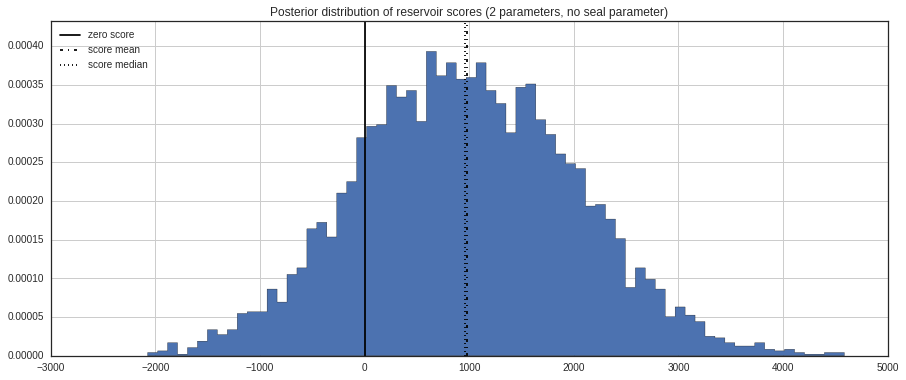

In [242]:
figsize(15, 6)

_hist = plt.hist(res_score_samples1, bins=70, normed=True, histtype="stepfilled")
plt.title("Posterior distribution of reservoir scores (2 parameters, no seal parameter)")
plt.vlines(0, 0, 1.1 * np.max(_hist[0]), label="zero score",
           linestyles="-")
plt.vlines(res_score_samples1.mean(), 0, 1.1 * np.max(_hist[0]),
           label="score mean", linestyles="-.")
plt.vlines(np.median(res_score_samples1), 0, 1.1 * np.max(_hist[0]),
           label="score median", linestyles=":")
plt.legend(loc="upper left");
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist[0]))

negative_cases1 = (res_score_samples1<0).sum()/5000
print("Portion of cases in which the score is negative:",negative_cases1)
print("Mean of posterior distribution:",res_score_samples1.mean())
print("Median of posterior distribution:",np.median(res_score_samples1))

- describe modelling process 
- first only 2 parameters:
    - distribution of scores defined by reservoir thickness (positive) and reservoir depth (negative)
    - score as an abstract numerical valuation of the reservoir (not monetary, very simplified)

In [243]:
seal_top = pm.Normal("seal_top", -2000, 1./np.square(7.))
seal_to = 20 #Minimum treshold for seal to be safe

@pm.deterministic
def score_if_seal(res_thickness=res_thickness, res_depth=res_top, \
                  th_v=th_v, dp_c=dp_c):
    return (th_v * res_thickness + (dp_c * res_depth))

@pm.deterministic
def true_score2(seal_top=seal_top, res_top=res_top,
                 dp_c=dp_c, res_depth=res_top, 
                 score_if_seal = score_if_seal):
    seal_th = seal_top - res_top
    if seal_th >= seal_to:
        x = score_if_seal
    else:
        x = (dp_c * res_depth)
    return x


model2 = pm.Model([true_score2, res_thickness, score_if_seal, res_top, res_bottom, seal_top])

M2 = pm.MCMC(model2)
M2.sample(iter=5000)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.8 sec

In [244]:
M2.trace("true_score2")[:]
res_th_samples2 = M2.trace("res_thickness")[:]
seal_tp_samples2 = M2.trace("seal_top")[:]
res_tp_samples2 = M2.trace("res_top")[:]
res_dp_samples2 = M2.trace("res_top")[:]
res_bt_samples2 = M2.trace("res_bottom")[:]
res_score_samples2 = M2.trace("true_score2")[:]

Portion of cases in which the score is negative: 0.2958
Mean of posterior distribution: 476.014834403
Median of posterior distribution: 645.316013835


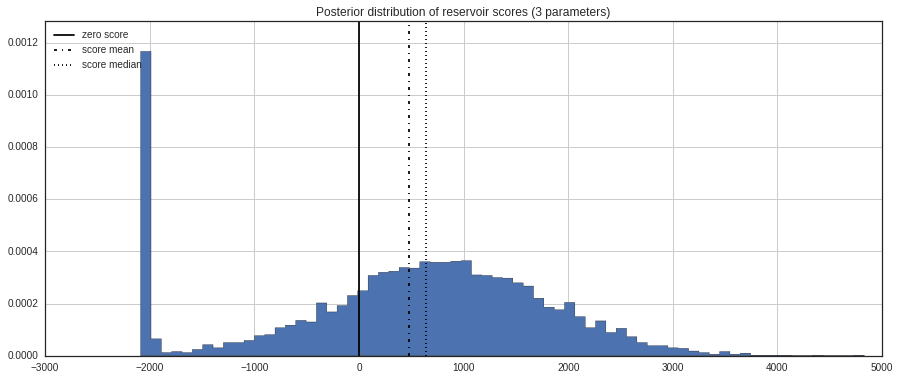

In [245]:
figsize(15, 6)

_hist = plt.hist(res_score_samples2, bins=70, normed=True, histtype="stepfilled")
plt.title("Posterior distribution of reservoir scores (3 parameters)")
plt.vlines(0, 0, 1.1 * np.max(_hist[0]), label="zero score",
           linestyles="-")
plt.vlines(res_score_samples2.mean(), 0, 1.1 * np.max(_hist[0]),
           label="score mean", linestyles="-.")
plt.vlines(np.median(res_score_samples2), 0, 1.1 * np.max(_hist[0]),
           label="score median", linestyles=":")
plt.legend(loc="upper left");
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist[0]))

negative_cases2 = (res_score_samples2<0).sum()/5000
print("Portion of cases in which the score is negative:",negative_cases2)
print("Mean of posterior distribution:",res_score_samples2.mean())
print("Median of posterior distribution:",np.median(res_score_samples2))

- model including seal reliability as a third parameter
- explain "seal failure" cases score
- distribution comparable to before, but now high concentration of "seal failure" cases
- increase in negative scores and significant shift of mean to the "left"

### Designing the loss function
- case: interest to estimate the reservoir score as precisely as possible or rather: to find the least bad estimate of the true value of the score
- disregarding subjective preferences and weight by an individual actor (decision maker), standard symmetric loss functions can be applied to find the objectively most precise estimate
- see absolute loss and squared loss functions

In [246]:
res_score = res_score_samples2
estimates_g = np.arange(-5000,5000,50)

In [247]:
#I  - STANDARD LOSS FUNCTIONS
#Ia - Symmetric absolute loss function
def abs_loss(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = estimate_s < true_s
        overest = estimate_s > true_s
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])
        return loss_s
    
def abs_loss2(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        for i in loss_s:
            loss_s[i] = abs(estimate_s - true_s[i])
        return loss_s

#Symmetric absolute loss for one given value
def simple_abs_loss(estimate_s, true_s):
        loss_s = abs(true_s - estimate_s)
        return loss_s
    
#Ib - Symmetric squared loss function
def sqr_loss(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = estimate_s < true_s
        overest = estimate_s > true_s
        loss_s[underest] = (true_s[underest] - estimate_s)**2
        loss_s[overest] = (estimate_s - true_s[overest])**2
        return loss_s
    
def sqr_loss2(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        for i in loss_s:
            loss_s[i] = abs(estimate_s - true_s[i])**2
        return loss_s
    
#Symmetric squared loss for one given value
def simple_sqr_loss(estimate_s, true_s):
        loss_s = abs(true_s - estimate_s)**2
        return loss_s

In [248]:
given_score1=-750
given_score2=0
given_score3=750

expected_absloss_s1 = lambda estimate_s: simple_abs_loss(estimate_s, given_score1)
expected_absloss_s2 = lambda estimate_s: simple_abs_loss(estimate_s, given_score2)
expected_absloss_s3 = lambda estimate_s: simple_abs_loss(estimate_s, given_score3)

expected_sqrloss_s1 = lambda estimate_s: simple_sqr_loss(estimate_s, given_score1)
expected_sqrloss_s2 = lambda estimate_s: simple_sqr_loss(estimate_s, given_score2)
expected_sqrloss_s3 = lambda estimate_s: simple_sqr_loss(estimate_s, given_score3)

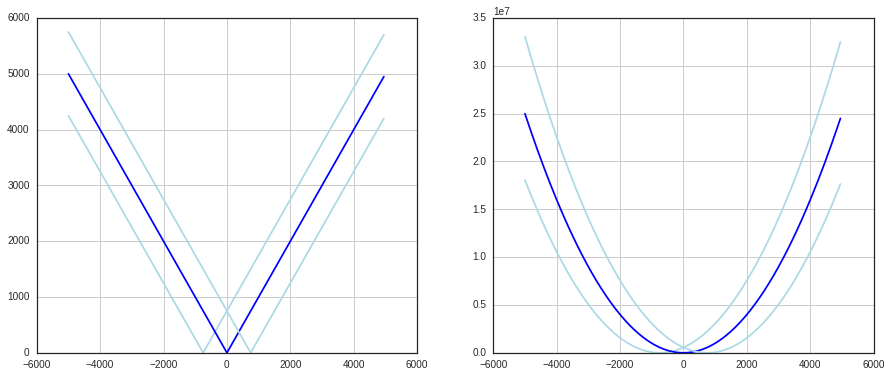

In [249]:
figsize(15, 6)
fig, ax = plt.subplots(1, 2)
ax[0].grid()
ax[1].grid()

#absolute
absloss = [expected_absloss_s1(e) for e in estimates_g]
ax[0].plot(estimates_g, absloss, color = 'lightblue')

absloss = [expected_absloss_s2(e) for e in estimates_g]
ax[0].plot(estimates_g, absloss, color = 'blue')

absloss = [expected_absloss_s3(e) for e in estimates_g]
ax[0].plot(estimates_g, absloss, color = 'lightblue')

#squared
sqrloss = [expected_sqrloss_s1(e) for e in estimates_g]
ax[1].plot(estimates_g, sqrloss, color = 'lightblue')

sqrloss = [expected_sqrloss_s2(e) for e in estimates_g]
ax[1].plot(estimates_g, sqrloss, color = 'blue')

sqrloss = [expected_sqrloss_s3(e) for e in estimates_g]
ax[1].plot(estimates_g, sqrloss, color = 'lightblue');

In [250]:
estimates_s = np.arange(-3000,6000,5)

Bayes action (min. expected loss) using absolute loss: 645.00
Bayes action (min. expected loss) using squared loss: 476.01


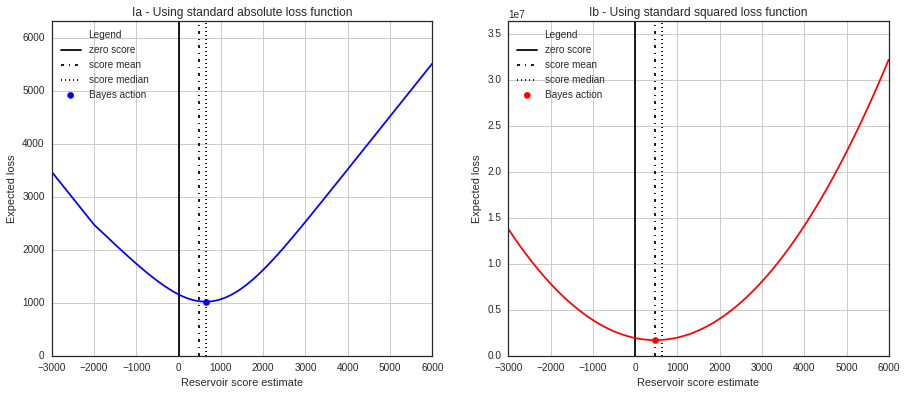

In [251]:
figsize(15, 6)
fig, ax = plt.subplots(1, 2)

ax[0].grid()
ax[0].vlines(0, 0, 1.1 * np.max(absloss), label="zero score", linestyles="-")
ax[0].vlines(res_score.mean(), 0, 1.1 * np.max(absloss), label="score mean", linestyles="-.")
ax[0].vlines(np.median(res_score_samples2), 0, 1.1 * np.max(absloss), label="score median", linestyles=":")
ax[0].set_xlabel("Reservoir score estimate")
ax[0].set_ylabel("Expected loss")
ax[0].set_title("Ia - Using standard absolute loss function")
ax[0].set_xlim(estimates_s[0], estimates_s[-1])
ax[0].set_ylim(0,1.1 * np.max(absloss))

ax[1].grid()
ax[1].vlines(0, 0, 1.1 * np.max(sqrloss), label="zero score", linestyles="-")
ax[1].vlines(res_score.mean(), 0, 1.1 * np.max(sqrloss), label="score mean", linestyles="-.")
ax[1].vlines(np.median(res_score_samples2), 0, 1.1 * np.max(sqrloss), label="score median", linestyles=":")
ax[1].set_xlabel("Reservoir score estimate")
ax[1].set_ylabel("Expected loss")
ax[1].set_title("Ib - Using standard squared loss function")
ax[1].set_xlim(estimates_s[0], estimates_s[-1])
ax[1].set_ylim(0,1.1 * np.max(sqrloss))

#Expected absolute loss
expected_abs_loss = lambda estimate_s: abs_loss(estimate_s, res_score).mean()
absloss = [expected_abs_loss(e) for e in estimates_s]
ax[0].plot(estimates_s, absloss, color = 'blue')
_min_absloss = sop.fmin(expected_abs_loss, 40,disp = False)
ax[0].scatter(_min_absloss, np.min(absloss), s = 40, color = 'blue', label = "Bayes action")
print("Bayes action (min. expected loss) using absolute loss: %.2f" % (_min_absloss))

#Expected squared loss
expected_sqr_loss = lambda estimate_s: sqr_loss(estimate_s, res_score).mean()
sqrloss = [expected_sqr_loss(e) for e in estimates_s]
ax[1].plot(estimates_s, sqrloss, color = 'red')
_min_sqrloss = sop.fmin(expected_sqr_loss, 40,disp = False)
ax[1].scatter(_min_sqrloss, np.min(sqrloss), s = 40, color = 'red', label = "Bayes action")
print("Bayes action (min. expected loss) using squared loss: %.2f" % (_min_sqrloss))

ax[0].legend(loc="upper left", scatterpoints=1, title="Legend");
ax[1].legend(loc="upper left", scatterpoints=1, title="Legend");

In [252]:
#Weight factors
ov = 1.25
ov_b = 2

In [253]:
#II - Variations of asymmetric absolute loss function

#IIa - Adaption: Underestimation and overestimation irrelevant if both negative (Introducing irrelevant cases)
def res_score_loss1(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        overest = (estimate_s > true_s) & (estimate_s >= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])
        return loss_s
    
#IIa - Adaption: Overestimation worse than underestimation
def res_score_loss2(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        overest = (estimate_s > true_s) & (estimate_s >= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        return loss_s    
    
#IIc - Adaption: Introducing "worst" overestimation
def res_score_loss3(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        overest = (estimate_s > true_s) & (estimate_s >= 0)
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s
    
#IId - Adaption: Introducing "worst" underestimation
def res_score_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) & (estimate_s >= 0)
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = true_s[underest_bad]
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s
    
#IId.2 - Version for given values
def res_score_lossG(estimate_s, true_s):
        if estimate_s < true_s:
            if estimate_s <= 0 and true_s > 0:
                loss_s = true_s #bad case of underestimation
            elif estimate_s < true_s and true_s <= 0: #"good"/irrelevant underestimation
                loss_s = 0
            else:
                loss_s = (true_s - estimate_s) #normal underestimation
        elif estimate_s > true_s:
            if estimate_s > 0 and true_s <= 0:
                loss_s = (estimate_s - true_s)*ov_b #bad case of overestimation
            elif estimate_s > true_s and estimate_s <= 0: #"good"/irrelevant overestimation
                loss_s = 0
            else:
                loss_s = (estimate_s - true_s)*ov #normal overestimation
        else:
            loss_s = 0
        return loss_s

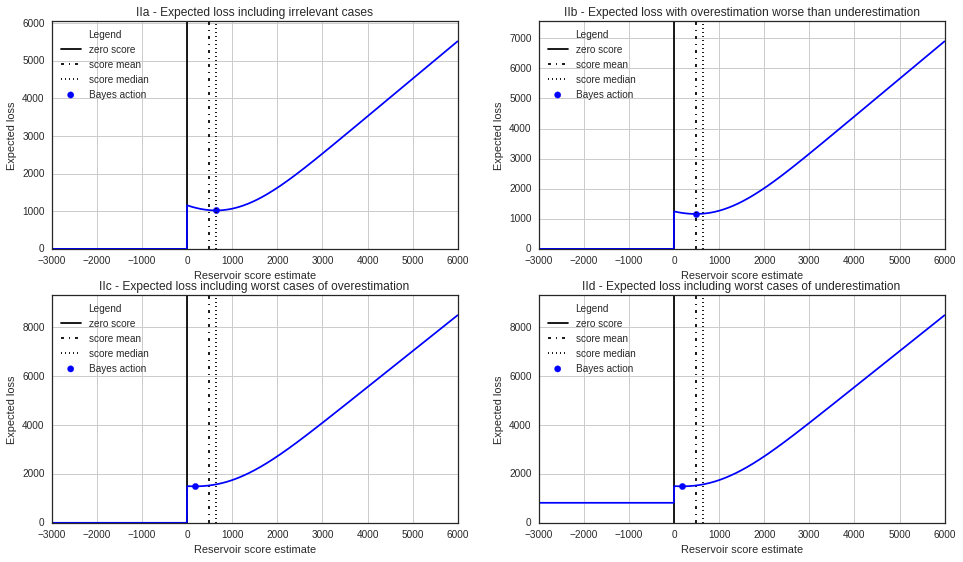

In [254]:
figsize(16, 9)
fig, ax = plt.subplots(2, 2)

#IIa
expected_loss_s = lambda estimate_s: res_score_loss1(estimate_s, res_score).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss1 = sop.fmin(expected_loss_s, 40, disp = False)
ax[0,0].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[0,0].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
ax[0,0].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[0,0].plot(estimates_s, loss, color = 'blue')
ax[0,0].scatter(_min_loss1, expected_loss_s(_min_loss1), s = 40, color = 'blue', label = "Bayes action")
ax[0,0].set_title("""IIa - Expected loss including irrelevant cases""")    
ax[0,0].set_xlabel("Reservoir score estimate")
ax[0,0].set_ylabel("Expected loss")
ax[0,0].set_xlim(estimates_s[0], estimates_s[-1])
ax[0,0].set_ylim(0,1.1 * np.max(loss))
ax[0,0].grid()
ax[0,0].legend(loc="upper left", scatterpoints=1, title="Legend");

#IIb
expected_loss_s = lambda estimate_s: res_score_loss2(estimate_s, res_score).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss2 = sop.fmin(expected_loss_s, 40, disp = False)
ax[0,1].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[0,1].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
ax[0,1].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[0,1].plot(estimates_s, loss, color = 'blue')
ax[0,1].scatter(_min_loss2, expected_loss_s(_min_loss2), s = 40, color = 'blue', label = "Bayes action")
ax[0,1].set_title("""IIb - Expected loss with overestimation worse than underestimation""")    
ax[0,1].set_xlabel("Reservoir score estimate")
ax[0,1].set_ylabel("Expected loss")
ax[0,1].set_xlim(estimates_s[0], estimates_s[-1])
ax[0,1].set_ylim(0,1.1 * np.max(loss))
ax[0,1].grid()
ax[0,1].legend(loc="upper left", scatterpoints=1, title="Legend");

#IIc
expected_loss_s = lambda estimate_s: res_score_loss3(estimate_s, res_score).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss3 = sop.fmin(expected_loss_s, 40, disp = False)
ax[1,0].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[1,0].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
ax[1,0].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[1,0].plot(estimates_s, loss, color = 'blue')
ax[1,0].scatter(_min_loss3, expected_loss_s(_min_loss3), s = 40, color = 'blue', label = "Bayes action")
ax[1,0].set_title("""IIc - Expected loss including worst cases of overestimation""")    
ax[1,0].set_xlabel("Reservoir score estimate")
ax[1,0].set_ylabel("Expected loss")
ax[1,0].set_xlim(estimates_s[0], estimates_s[-1])
ax[1,0].set_ylim(0,1.1 * np.max(loss))
ax[1,0].grid()
ax[1,0].legend(loc="upper left", scatterpoints=1, title="Legend");

#IId
expected_loss_s = lambda estimate_s: res_score_loss4(estimate_s, res_score).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss4 = sop.fmin(expected_loss_s, 40, disp = False)
ax[1,1].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[1,1].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
ax[1,1].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[1,1].plot(estimates_s, loss, color = 'blue')
ax[1,1].scatter(_min_loss4, expected_loss_s(_min_loss4), s = 40, color = 'blue', label = "Bayes action")
ax[1,1].set_title("""IId - Expected loss including worst cases of underestimation""")    
ax[1,1].set_xlabel("Reservoir score estimate")
ax[1,1].set_ylabel("Expected loss")
ax[1,1].set_xlim(estimates_s[0], estimates_s[-1])
ax[1,1].set_ylim(0,1.1 * np.max(loss))
ax[1,1].grid()
ax[1,1].legend(loc="upper left", scatterpoints=1, title="Legend");

In [255]:
print("Portion of cases in which the score is negative:",negative_cases2)
print("Mean of posterior distribution: %d" % (res_score.mean()))  
print("Median of posterior distribution:",np.median(res_score))
print()
print("IIa - Bayes action (min. expected loss): %.2f; expected loss: %f" % (_min_loss1, expected_loss_s(_min_loss1)))
print("IIb - Bayes action (min. expected loss): %.2f; expected loss: %f" % (_min_loss2, expected_loss_s(_min_loss2)))
print("IIc - Bayes action (min. expected loss): %.2f; expected loss: %f" % (_min_loss3, expected_loss_s(_min_loss3)))
print("IId - Bayes action (min. expected loss): %.2f; expected loss: %f" % (_min_loss4, expected_loss_s(_min_loss4)))

Portion of cases in which the score is negative: 0.2958
Mean of posterior distribution: 476
Median of posterior distribution: 645.316013835

IIa - Bayes action (min. expected loss): 645.00; expected loss: 1570.958794
IIb - Bayes action (min. expected loss): 479.29; expected loss: 1523.796218
IIc - Bayes action (min. expected loss): 175.27; expected loss: 1490.640235
IId - Bayes action (min. expected loss): 175.27; expected loss: 1490.640235


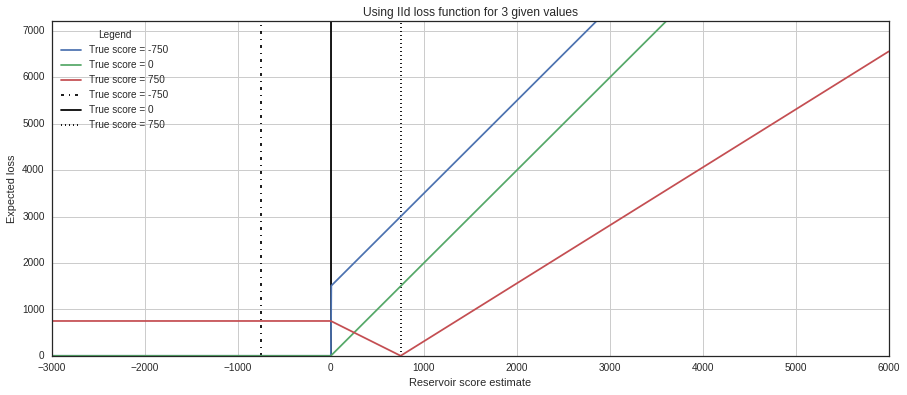

In [256]:
expected_loss_s1 = lambda estimate_s: res_score_lossG(estimate_s, given_score1)
expected_loss_s2 = lambda estimate_s: res_score_lossG(estimate_s, given_score2)
expected_loss_s3 = lambda estimate_s: res_score_lossG(estimate_s, given_score3)

figsize(15, 6)

loss = [expected_loss_s1(e) for e in estimates_s]
plt.plot(estimates_s, loss, label="True score = %d" % (given_score1))

loss = [expected_loss_s2(e) for e in estimates_s]
plt.plot(estimates_s, loss, label="True score = %d" % (given_score2))

loss = [expected_loss_s3(e) for e in estimates_s]
plt.plot(estimates_s, loss,label="True score = %d" % (given_score3))

plt.grid()
plt.vlines(given_score1, 0, 1.1 * np.max(loss), label="True score = %d" % (given_score1), linestyles="-.")
plt.vlines(given_score2, 0, 1.1 * np.max(loss), label="True score = %d" % (given_score2), linestyles="-")
plt.vlines(given_score3, 0, 1.1 * np.max(loss), label="True score = %d" % (given_score3), linestyles=":")
plt.xlabel("Reservoir score estimate")
plt.ylabel("Expected loss")
plt.title("Using IId loss function for 3 given values")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss));
plt.legend(loc="upper left", title="Legend");

### Including different risk affinities


In [257]:
#Risk parameters
risks_s = np.arange(0.5, 1.6, 0.25)
print(risks_s)

#Risk max loss
risks_s2 = np.arange(5000, 10000, 1000)
print(risks_s2)

[ 0.5   0.75  1.    1.25  1.5 ]
[5000 6000 7000 8000 9000]


In [258]:
#III - Introducing risk

#IIIa - Risk as a parameter influencing the weighting
def res_score_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) & (true_s >= 0)
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = true_s[underest_bad]
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*(ov_b*risk_s)
        return loss_s
    
def res_score_lossGR(estimate_s, true_s, risk_s):
        if estimate_s < true_s:
            if estimate_s <= 0 and true_s > 0:
                loss_s = true_s #bad case of underestimation
            elif estimate_s < true_s and true_s <= 0: #"good"/irrelevant underestimation
                loss_s = 0
            else:
                loss_s = (true_s - estimate_s) #normal underestimation
        elif estimate_s > true_s:
            if estimate_s > 0 and true_s <= 0:
                loss_s = (estimate_s - true_s)*(ov_b*risk_s) #bad case of overestimation
            elif estimate_s > true_s and estimate_s <= 0: #"good"/irrelevant overestimation
                loss_s = 0
            else:
                loss_s = (estimate_s - true_s)*(ov*risk_s) #normal overestimation
        else:
            loss_s = 0
        return loss_s
    
#IIIb - Risk as a max. loss
def res_score_lossR2(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) & (estimate_s >= 0)
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) & (true_s >= 0)
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = true_s[underest_bad]
        loss_s[overest] = (estimate_s - true_s[overest])*((ov*(risk_s/risks_s2[2])))
        loss_s[overest_bad] = risk_s
        return loss_s

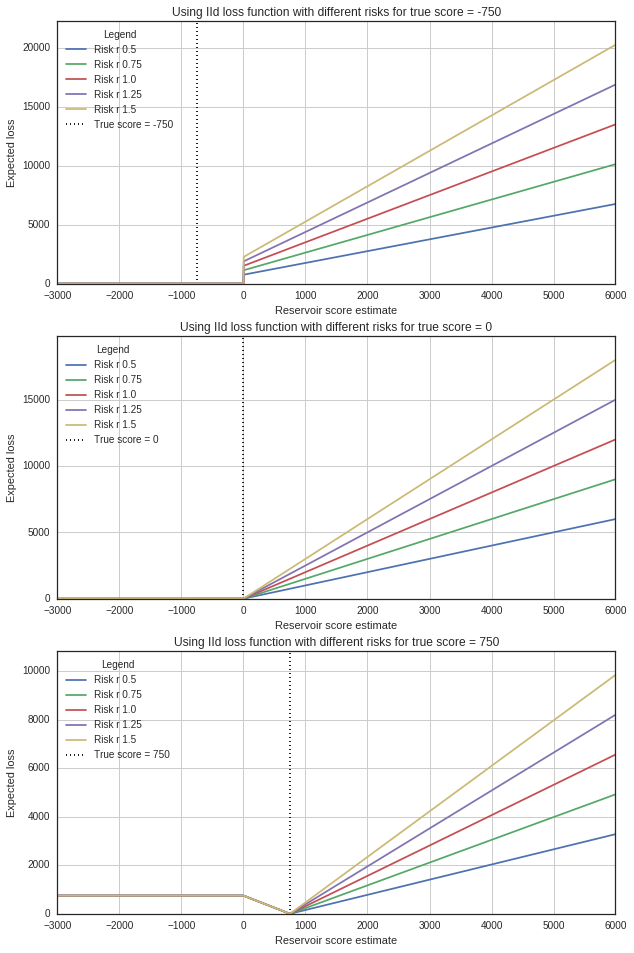

In [259]:
expected_loss_s1 = lambda estimate_s, risk_s: res_score_lossGR(estimate_s, given_score1, risk_s)
expected_loss_s2 = lambda estimate_s, risk_s: res_score_lossGR(estimate_s, given_score2, risk_s)
expected_loss_s3 = lambda estimate_s, risk_s: res_score_lossGR(estimate_s, given_score3, risk_s)
figsize(10, 16)
fig, ax = plt.subplots(3,1)

for r in risks_s:
    loss = [expected_loss_s1(e, r) for e in estimates_s]
    ax[0].plot(estimates_s, loss, label = "Risk r "+str(r))
ax[0].grid()
ax[0].vlines(given_score1, 0, 1.1 * np.max(loss), label="True score = %d" % (given_score1), linestyles=":")
ax[0].set_xlabel("Reservoir score estimate")
ax[0].set_ylabel("Expected loss")
ax[0].set_title("Using IId loss function with different risks for true score = %d" % (given_score1))
ax[0].set_xlim(estimates_s[0], estimates_s[-1])
ax[0].set_ylim(0,1.1 * np.max(loss));
ax[0].legend(loc="upper left", title="Legend");

for r in risks_s:
    loss = [expected_loss_s2(e, r) for e in estimates_s]
    ax[1].plot(estimates_s, loss, label = "Risk r "+str(r))
ax[1].grid()
ax[1].vlines(given_score2, 0, 1.1 * np.max(loss), label="True score = %d" % (given_score2), linestyles=":")
ax[1].set_xlabel("Reservoir score estimate")
ax[1].set_ylabel("Expected loss")
ax[1].set_title("Using IId loss function with different risks for true score = %d" % (given_score2))
ax[1].set_xlim(estimates_s[0], estimates_s[-1])
ax[1].set_ylim(0,1.1 * np.max(loss));
ax[1].legend(loc="upper left", title="Legend");

for r in risks_s:
    loss = [expected_loss_s3(e, r) for e in estimates_s]
    ax[2].plot(estimates_s, loss, label = "Risk r "+str(r))
ax[2].grid()
ax[2].vlines(given_score3, 0, 1.1 * np.max(loss), label="True score = %d" % (given_score3), linestyles=":")
ax[2].set_xlabel("Reservoir score estimate")
ax[2].set_ylabel("Expected loss")
ax[2].set_title("Using IId loss function with different risks for true score = %d" % (given_score3))
ax[2].set_xlim(estimates_s[0], estimates_s[-1])
ax[2].set_ylim(0,1.1 * np.max(loss));
ax[2].legend(loc="upper left", title="Legend");

Bayes action (minimum) at risk r 0.50: 772.36
Bayes action (minimum) at risk r 0.75: 433.98
Bayes action (minimum) at risk r 1.00: 175.27
Bayes action (minimum) at risk r 1.25: -4.00
Bayes action (minimum) at risk r 1.50: -4.00


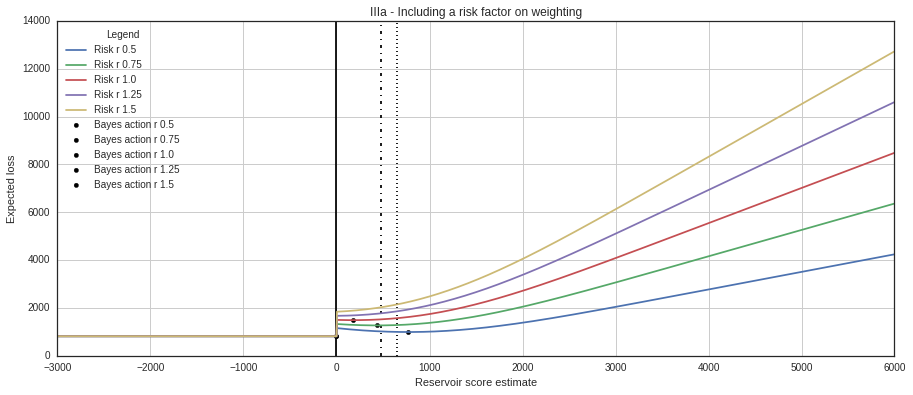

In [260]:
figsize(15, 6)
  
expected_loss_s = lambda estimate_s, risk_s: res_score_lossR(estimate_s, res_score, risk_s).mean()

for r in risks_s:
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_s, 40, args=(r,),disp = False)
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss_s(_min_score,r), s = 20, color = 'black', label = "Bayes action r "+str(r))
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    
plt.title("""IIIa - Including a risk factor on weighting""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Reservoir score estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()

Bayes action (minimum) at risk r 5000.00: 1110.78
Bayes action (minimum) at risk r 6000.00: 1018.25
Bayes action (minimum) at risk r 7000.00: 949.98
Bayes action (minimum) at risk r 8000.00: 880.64
Bayes action (minimum) at risk r 9000.00: 821.88


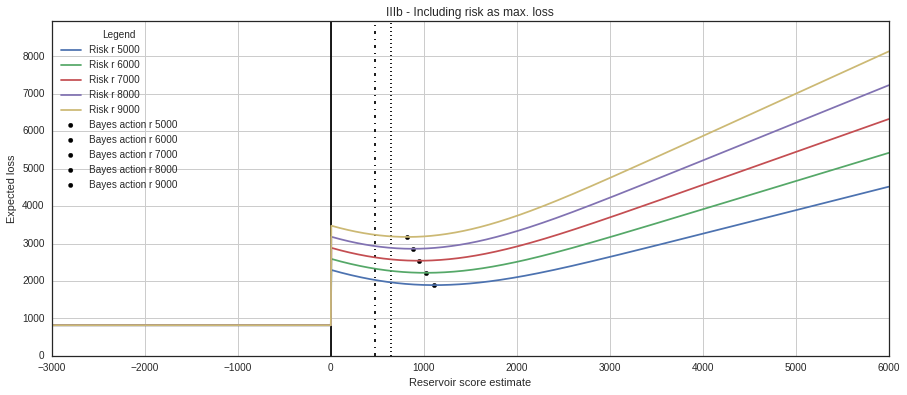

In [261]:
figsize(15, 6)
  
expected_loss_s = lambda estimate_s, risk_s: res_score_lossR2(estimate_s, res_score, risk_s).mean()

for r in risks_s2:
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_s, 40, args=(r,),disp = False)
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss_s(_min_score,r), s = 20, color = 'black', label = "Bayes action r "+str(r))
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    
plt.title("""IIIb - Including risk as max. loss""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Reservoir score estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()

### Additional information in form of thickness likelihoods and reduced uncertainty

In [262]:
std1 = 20
std2 = 60

In [263]:
@pm.stochastic
def layer_thickness1(value = 0, alpha = seal_top, beta = res_top):
    a = alpha-beta
    return pm.normal_like(a, 25., 1./np.square(std1))

@pm.stochastic
def layer_thickness2(value = 0,  beta = res_top, gamma = res_bottom):
    b = beta-gamma
    return pm.normal_like(b, 180., 1./np.square(std2))

model3 = pm.Model([alpha, beta, gamma, layer_thickness1, layer_thickness2])

M3 = pm.MCMC(model3)
M3.sample(iter=10000, burn = 1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 4.5 sec

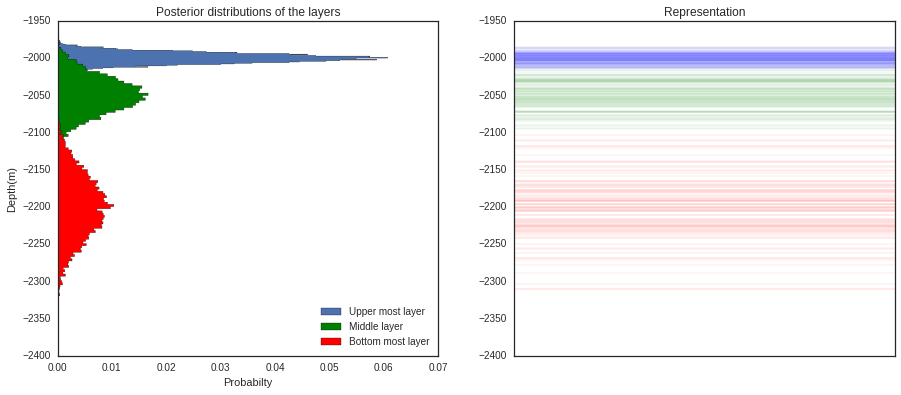

In [264]:
figsize(15,6)
fig, ax = plt.subplots(1, 2)
alpha_samples2 = M3.trace('alpha')[:]
beta_samples2 = M3.trace('beta')[:]
gamma_samples2 = M3.trace('gamma')[:]

alpha_samples2, alpha_samples_all2 = M3.trace('alpha')[-80:], M3.trace("alpha")[:]
beta_samples2, beta_samples_all2 = M3.trace('beta')[-80:], M3.trace("beta")[:]
gamma_samples2, gamma_samples_all2 = M3.trace('gamma')[-80:], M3.trace('gamma')[:]

#parameters = zip(alpha_samples2, beta_samples2, gamma_samples2)
#parameters_all = zip(alpha_samples_all2, beta_samples_all2, gamma_samples_all2)
ax[0].hist(alpha_samples_all2, histtype='stepfilled', bins=60, alpha=1,
    label="Upper most layer", normed=True,  orientation="horizontal")
ax[0].hist(beta_samples_all2, histtype='stepfilled', bins=60, alpha=1,
    label="Middle layer", normed=True, color = "g",  orientation="horizontal")
ax[0].hist(gamma_samples_all2, histtype='stepfilled', bins=120, alpha=1,
 label="Bottom most layer", normed=True, color = "r", orientation="horizontal")

ax[0].legend(loc = 0)
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_ylabel("Depth(m)")
ax[0].set_xlabel("Probabilty")
ax[0].set_ylim([-2400,-1950])

ax[1].set_title("Representation")
ax[1].set_ylim([-2400,-1950])
ax[1].xaxis.set_visible(False)

for i in range(100):
    ax[1].axhline(alpha_samples_all2[-i], alpha = 0.05)
    ax[1].axhline(beta_samples_all2[-i], c = "g", alpha = 0.05)
    ax[1].axhline(gamma_samples_all2[-i],c = "r", alpha = 0.05)

In [265]:
@pm.deterministic
def score_if_seal_fail(res_depth=res_top, dp_c=dp_c):
    return (dp_c * res_depth)

@pm.deterministic
def true_score3(seal_top=seal_top, res_top=res_top,
                 dp_c=dp_c, res_depth=res_top, 
                 score_if_seal = score_if_seal, score_if_seal_fail=score_if_seal_fail):
    seal_th = seal_top - res_top
    seal_failure = seal_th < seal_to
    x = np.zeros_like(seal_top)
    x[~seal_failure] = score_if_seal[~seal_failure]
    x[seal_failure] = score_if_seal_fail[seal_failure]
    return x

model4 = pm.Model([true_score3, score_if_seal, score_if_seal_fail, layer_thickness1, layer_thickness2, res_top, res_bottom, seal_top])

M4= pm.MCMC(model4)
M4.sample(iter=10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 4.3 sec

In [266]:
res_score2 = M4.trace("true_score3")[:]

Portion of cases in which the score is negative: 0.2958
Mean of posterior distribution: 702.532187564
Median of posterior distribution: 1076.79848602


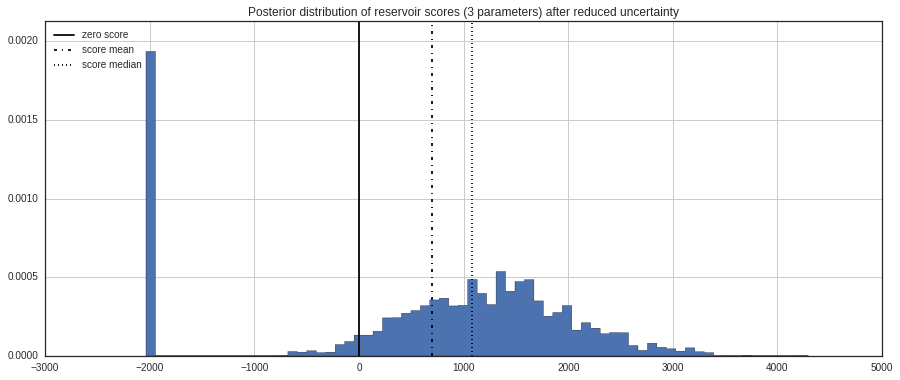

In [267]:
figsize(15, 6)

_hist = plt.hist(res_score2, bins=70, normed=True, histtype="stepfilled")
plt.title("Posterior distribution of reservoir scores (3 parameters) after reduced uncertainty")
plt.vlines(0, 0, 1.1 * np.max(_hist[0]), label="zero score", linestyles="-")
plt.vlines(res_score2.mean(), 0, 1.1 * np.max(_hist[0]), label="score mean", linestyles="-.")
plt.vlines(np.median(res_score2), 0, 1.1 * np.max(_hist[0]), label="score median", linestyles=":")
plt.legend(loc="upper left");
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist[0]))

negative_cases3 = (res_score2<0).sum()/9000
print("Portion of cases in which the score is negative:",negative_cases2)
print("Mean of posterior distribution:",res_score2.mean())
print("Median of posterior distribution:",np.median(res_score2))

Bayes action (minimum) at risk r 0.50: 1231.13
Bayes action (minimum) at risk r 0.75: 948.61
Bayes action (minimum) at risk r 1.00: 721.17
Bayes action (minimum) at risk r 1.25: 513.15
Bayes action (minimum) at risk r 1.50: 343.25


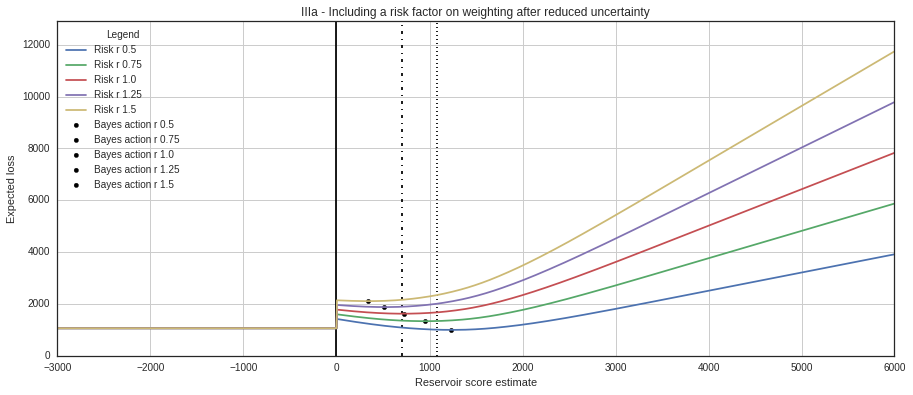

In [268]:
figsize(15, 6)
  
expected_loss_s= lambda estimate_s, risk_s: res_score_lossR(estimate_s, res_score2, risk_s).mean()

for r in risks_s:
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_s, 40, args=(r,),disp = False)
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss_s(_min_score,r), s = 20, color = 'black', label = "Bayes action r "+str(r))
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    
plt.title("""IIIa - Including a risk factor on weighting after reduced uncertainty""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
plt.vlines(res_score2.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
plt.vlines(np.median(res_score2), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Reservoir score estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()

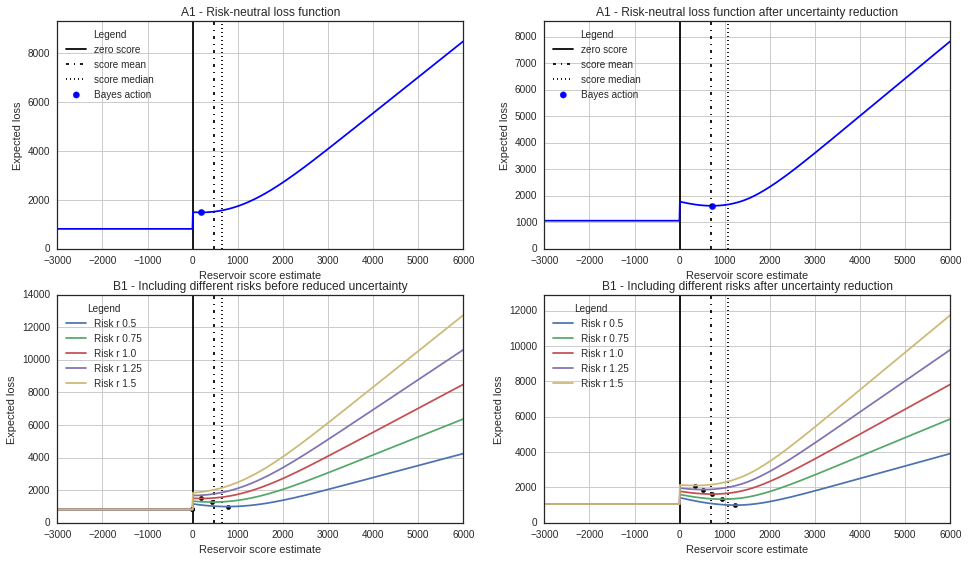

In [269]:
figsize(16, 9)
fig, ax = plt.subplots(2, 2)

# No reduced uncertainty, risk-neutral
expected_loss_s = lambda estimate_s: res_score_loss4(estimate_s, res_score).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss4 = sop.fmin(expected_loss_s, 40, disp = False)
ax[0,0].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[0,0].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
ax[0,0].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[0,0].plot(estimates_s, loss, color = 'blue')
ax[0,0].scatter(_min_loss4, expected_loss_s(_min_loss4), s = 40, color = 'blue', label = "Bayes action")
ax[0,0].set_title("""A1 - Risk-neutral loss function""")    
ax[0,0].set_xlabel("Reservoir score estimate")
ax[0,0].set_ylabel("Expected loss")
ax[0,0].set_xlim(estimates_s[0], estimates_s[-1])
ax[0,0].set_ylim(0,1.1 * np.max(loss))
ax[0,0].grid()
ax[0,0].legend(loc="upper left", scatterpoints=1, title="Legend");

# Reduced uncertainty, risk-neutral
expected_loss_s = lambda estimate_s: res_score_loss4(estimate_s, res_score2).mean()

loss = [expected_loss_s(e) for e in estimates_s]
_min_loss4 = sop.fmin(expected_loss_s, 40, disp = False)
ax[0,1].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[0,1].vlines(res_score2.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
ax[0,1].vlines(np.median(res_score2), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[0,1].plot(estimates_s, loss, color = 'blue')
ax[0,1].scatter(_min_loss4, expected_loss_s(_min_loss4), s = 40, color = 'blue', label = "Bayes action")
ax[0,1].set_title("""A1 - Risk-neutral loss function after uncertainty reduction""")    
ax[0,1].set_xlabel("Reservoir score estimate")
ax[0,1].set_ylabel("Expected loss")
ax[0,1].set_xlim(estimates_s[0], estimates_s[-1])
ax[0,1].set_ylim(0,1.1 * np.max(loss))
ax[0,1].grid()
ax[0,1].legend(loc="upper left", scatterpoints=1, title="Legend");

# No reduced uncertainty, different risks
BA_before = np.zeros_like(risks_s)
EL_before = np.zeros_like(risks_s)
expected_loss_s = lambda estimate_s, risk_s: res_score_lossR(estimate_s, res_score, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_s, 40, args=(r,),disp = False)
    ax[1,0].plot(estimates_s, loss, label = "Risk r "+str(r))
    ax[1,0].scatter(_min_score, expected_loss_s(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_before[counter] = _min_score
    EL_before[counter] = expected_loss_s(_min_score,r)
    counter += 1
    
ax[1,0].set_title("""B1 - Including different risks before reduced uncertainty""")    
ax[1,0].legend(loc="upper left", scatterpoints=1, title="Legend")
ax[1,0].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[1,0].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
ax[1,0].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[1,0].set_xlabel("Reservoir score estimate")
ax[1,0].set_ylabel("Expected loss")
ax[1,0].set_xlim(estimates_s[0], estimates_s[-1])
ax[1,0].set_ylim(0,1.1 * np.max(loss))
ax[1,0].grid()

# Reduced uncertainty, different risks
BA_after = np.zeros_like(risks_s)
EL_after = np.zeros_like(risks_s)
expected_loss_s= lambda estimate_s, risk_s: res_score_lossR(estimate_s, res_score2, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_s, 40, args=(r,),disp = False)
    ax[1,1].plot(estimates_s, loss, label = "Risk r "+str(r))
    ax[1,1].scatter(_min_score, expected_loss_s(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_after[counter] = _min_score
    EL_after[counter] = expected_loss_s(_min_score,r)
    counter += 1
        
ax[1,1].set_title("""B1 - Including different risks after uncertainty reduction""")    
ax[1,1].legend(loc="upper left", scatterpoints=1, title="Legend")
ax[1,1].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[1,1].vlines(res_score2.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
ax[1,1].vlines(np.median(res_score2), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[1,1].set_xlabel("Reservoir score estimate")
ax[1,1].set_ylabel("Expected loss")
ax[1,1].set_xlim(estimates_s[0], estimates_s[-1])
ax[1,1].set_ylim(0,1.1 * np.max(loss))
ax[1,1].grid()

### Quantifying the value of added information and uncertainty reduction
- for finding a better estimate or decision

In [270]:
print(BA_before)
print(BA_after)
BA_diff = BA_after - BA_before
print(BA_diff)
print()
print(EL_before)
print(EL_after)
EL_diff = EL_after - EL_before
print(EL_diff)

[ 772.36248779  433.98272705  175.27056885   -4.           -4.        ]
[ 1231.13171387   948.61047363   721.16931152   513.15490723   343.25354004]
[ 458.76922607  514.62774658  545.89874268  517.15490723  347.25354004]

[  994.07444594  1270.74869218  1490.64023464   817.67653406   817.67653406]
[  999.27158621  1335.56869935  1623.87278995  1878.81351493  2108.78981925]
[    5.19714027    64.82000717   133.23255531  1061.13698087  1291.11328519]


Observation: Minimum of expected loss increased for all actors and more for those with low risk affinity (more risk-averse). At the same time, Bayes action shifted to the positive side for all actors, implying a higher estimate. This shift was greater for actors with lower risk affinity (more risk-averse).

In [271]:
counter = 0
for r in risks_s:
    print("Bayes action shift due to uncertainty reduction for r %.2f: %.2f -- \
    Shift in expected loss = %.2f" % (r, BA_diff[counter], EL_diff[counter]))
    counter += 1

Bayes action shift due to uncertainty reduction for r 0.50: 458.77 --     Shift in expected loss = 5.20
Bayes action shift due to uncertainty reduction for r 0.75: 514.63 --     Shift in expected loss = 64.82
Bayes action shift due to uncertainty reduction for r 1.00: 545.90 --     Shift in expected loss = 133.23
Bayes action shift due to uncertainty reduction for r 1.25: 517.15 --     Shift in expected loss = 1061.14
Bayes action shift due to uncertainty reduction for r 1.50: 347.25 --     Shift in expected loss = 1291.11
